In [1]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install scanpy
!pip install cellrank

In [2]:
import scanpy as sc
import anndata
from scipy import io
from scipy.sparse import coo_matrix, csr_matrix
import numpy as np
import os
import pandas as pd
import scvelo as scv
import cellrank as cr
cr.logging.print_versions()


cellrank==1.5.1 scanpy==1.9.1 anndata==0.8.0 numpy==1.21.5 numba==0.55.1 scipy==1.9.1 pandas==1.5.3 pygpcca==1.0.4 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.10.4 scvelo==0.2.5 pygam==0.8.0 matplotlib==3.5.2 seaborn==0.11.2


In [3]:
import matplotlib.pyplot as plt

In [5]:
#read the loom file
import warnings
warnings.filterwarnings("ignore")
chow1 = anndata.read_loom("I:/Postdoc/LCdata/loom/Chow_1.loom")
chow1.var_names_make_unique()
chow1

AnnData object with n_obs × n_vars = 6075 × 55357
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [6]:
#read the loom file
chow2 = anndata.read_loom("I:/Postdoc/LCdata/loom/Chow_2.loom")
chow2.var_names_make_unique()
chow2

AnnData object with n_obs × n_vars = 7374 × 55357
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [7]:
#read the loom file
chow3 = anndata.read_loom("I:/Postdoc/LCdata/loom/Chow_3.loom")
chow3.var_names_make_unique()
chow3

AnnData object with n_obs × n_vars = 5043 × 55357
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [8]:
#read the loom file
CDAHFD1 = anndata.read_loom("I:/Postdoc/LCdata/loom/CDAHFD_1.loom")
CDAHFD1.var_names_make_unique()
CDAHFD1

AnnData object with n_obs × n_vars = 13109 × 55357
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [9]:
#read the loom file
CDAHFD2 = anndata.read_loom("I:/Postdoc/LCdata/loom/CDAHFD_2.loom")
CDAHFD2.var_names_make_unique()
CDAHFD2

AnnData object with n_obs × n_vars = 13738 × 55357
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [10]:
#read the loom file
BDL1 = anndata.read_loom("I:/Postdoc/LCdata/loom/BDL_1.loom")
BDL1.var_names_make_unique()
BDL1

AnnData object with n_obs × n_vars = 11173 × 55357
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [11]:
#read the loom file
BDL2 = anndata.read_loom("I:/Postdoc/LCdata/loom/BDL_2.loom")
BDL2.var_names_make_unique()
BDL2

AnnData object with n_obs × n_vars = 11665 × 55357
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [12]:
# read the phenotype data
cellID = pd.read_csv("I:/Postdoc/Mesenchymal_cells/cellID_obs_M.csv")
umap = pd.read_csv("I:/Postdoc/Mesenchymal_cells/cell_embeddings_M.csv")
cell_clusters = pd.read_csv("I:/Postdoc/Mesenchymal_cells/clusters_obs_M.csv")
treatment = pd.read_csv("I:/Postdoc/Mesenchymal_cells/treatment_M.csv")
samples = pd.read_csv("I:/Postdoc/Mesenchymal_cells/samples_M.csv")


In [13]:
#select cells to analysis
chow1 = chow1[np.isin(chow1.obs.index,cellID["x"])]
chow2 = chow2[np.isin(chow2.obs.index,cellID["x"])]
chow3 = chow3[np.isin(chow3.obs.index,cellID["x"])]
CDAHFD1 =CDAHFD1[np.isin(CDAHFD1.obs.index,cellID["x"])]
CDAHFD2 =CDAHFD2[np.isin(CDAHFD2.obs.index,cellID["x"])]
BDL1 =BDL1[np.isin(BDL1.obs.index,cellID["x"])]
BDL2 =BDL2[np.isin(BDL2.obs.index,cellID["x"])]




In [14]:
#Merge into one file
adata = chow1.concatenate(chow1,chow2,chow3,CDAHFD1,CDAHFD2,BDL1,BDL2)
adata

AnnData object with n_obs × n_vars = 6913 × 55357
    obs: 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [15]:
adata_index = pd.DataFrame(adata.obs.index)
adata_index = adata_index.rename(columns = {0:'Cell ID'})
adata_index = adata_index.rename(columns = {"CellID":'Cell ID'})





In [16]:
rep=lambda x : x.split("-")[0]
adata_index["Cell ID"]=adata_index["Cell ID"].apply(rep)



In [17]:
umap = umap.rename(columns = {'Unnamed: 0':'Cell ID'})
umap = umap[np.isin(umap["Cell ID"],adata_index["Cell ID"])] 
umap=umap.drop_duplicates(subset=["Cell ID"]) 
umap_ordered = adata_index.merge(umap, on = "Cell ID")
umap_ordered = umap_ordered.iloc[:,1:] 
adata.obsm['X_umap'] = umap_ordered.values 


In [18]:
#cell_clusters=cell_clusters.iloc[:,1:]
cell_clusters = cell_clusters.rename(columns = {'Unnamed: 0':'Cell ID'})
cell_clusters = cell_clusters[np.isin(cell_clusters["Cell ID"],adata_index["Cell ID"])]
cell_clusters=cell_clusters.drop_duplicates(subset=["Cell ID"]) 
cell_clusters_ordered = adata_index.merge(cell_clusters, on = "Cell ID")
cell_clusters_ordered = cell_clusters_ordered.iloc[:,1:]
adata.obs['clusters']=cell_clusters_ordered.values

In [19]:
#cell_clusters=cell_clusters.iloc[:,1:]
treatment = treatment.rename(columns = {'Unnamed: 0':'Cell ID'})
treatment = treatment[np.isin(treatment["Cell ID"],adata_index["Cell ID"])]
treatment=treatment.drop_duplicates(subset=["Cell ID"]) 
treatment_ordered = adata_index.merge(treatment, on = "Cell ID")
treatment_ordered = treatment_ordered.iloc[:,1:]
adata.obs['treatment']=treatment_ordered.values

In [20]:
#cell_clusters=cell_clusters.iloc[:,1:]
samples = samples.rename(columns = {'Unnamed: 0':'Cell ID'})
samples = samples[np.isin(samples["Cell ID"],adata_index["Cell ID"])]
samples=samples.drop_duplicates(subset=["Cell ID"]) 
samples_ordered = adata_index.merge(samples, on = "Cell ID")
samples_ordered = samples_ordered.iloc[:,1:]
adata.obs['samples']=samples_ordered.values

In [21]:
#RunRNA Velocity
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata)
scv.tl.velocity(adata, mode = "stochastic")
scv.tl.velocity_graph(adata)

Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:07) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:09) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:52) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/6913 [00:00<?, ?cells/s]

    finished (0:02:21) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [22]:
adata

AnnData object with n_obs × n_vars = 6913 × 55357
    obs: 'batch', 'clusters', 'treatment', 'samples', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

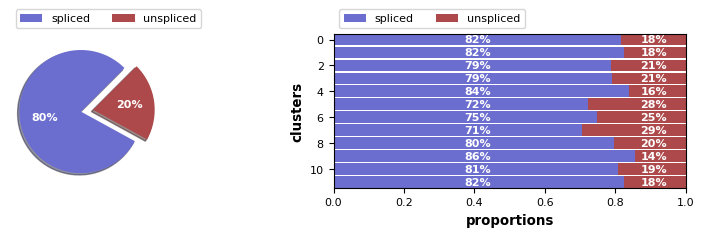

In [23]:
scv.pl.proportions(adata)

computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


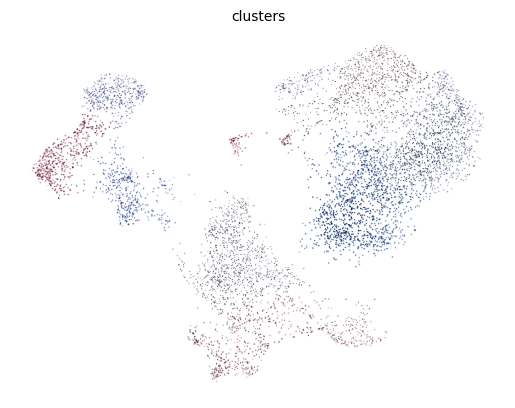

In [24]:
scv.pl.velocity_embedding(adata, basis = 'umap')

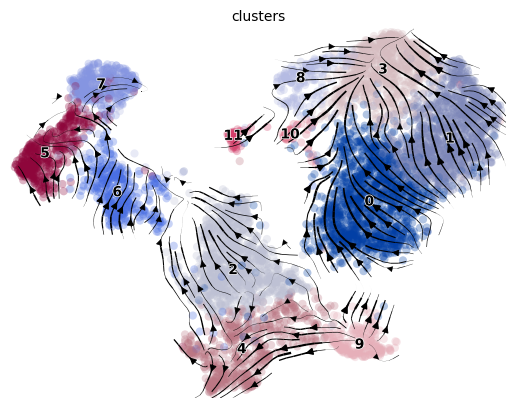

In [25]:
scv.pl.velocity_embedding_stream(adata, basis = 'umap')

In [26]:
scv.tl.recover_dynamics(adata)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)
adata.write('I:/Postdoc/Mesenchymal_cells/Mesenchymal_velocyte.h5ad', compression='gzip')

recovering dynamics (using 1/8 cores)


  0%|          | 0/1798 [00:00<?, ?gene/s]

    finished (0:35:25) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:01:14) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/6913 [00:00<?, ?cells/s]

    finished (0:00:35) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


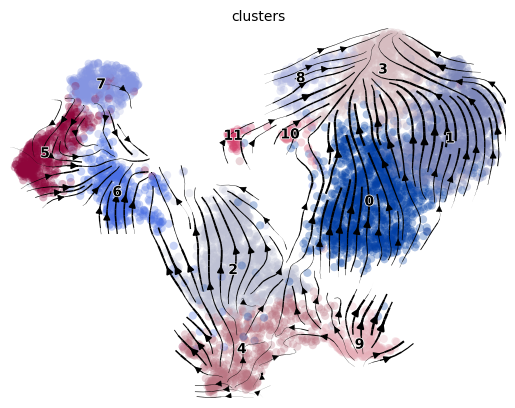

In [27]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

D:\software\Anaconda\lib\site-packages\fontTools\misc\py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


figure cannot be saved as pdf, using png instead.
saving figure to file I:/Postdoc/Mesenchymal_cells/velocity2.png


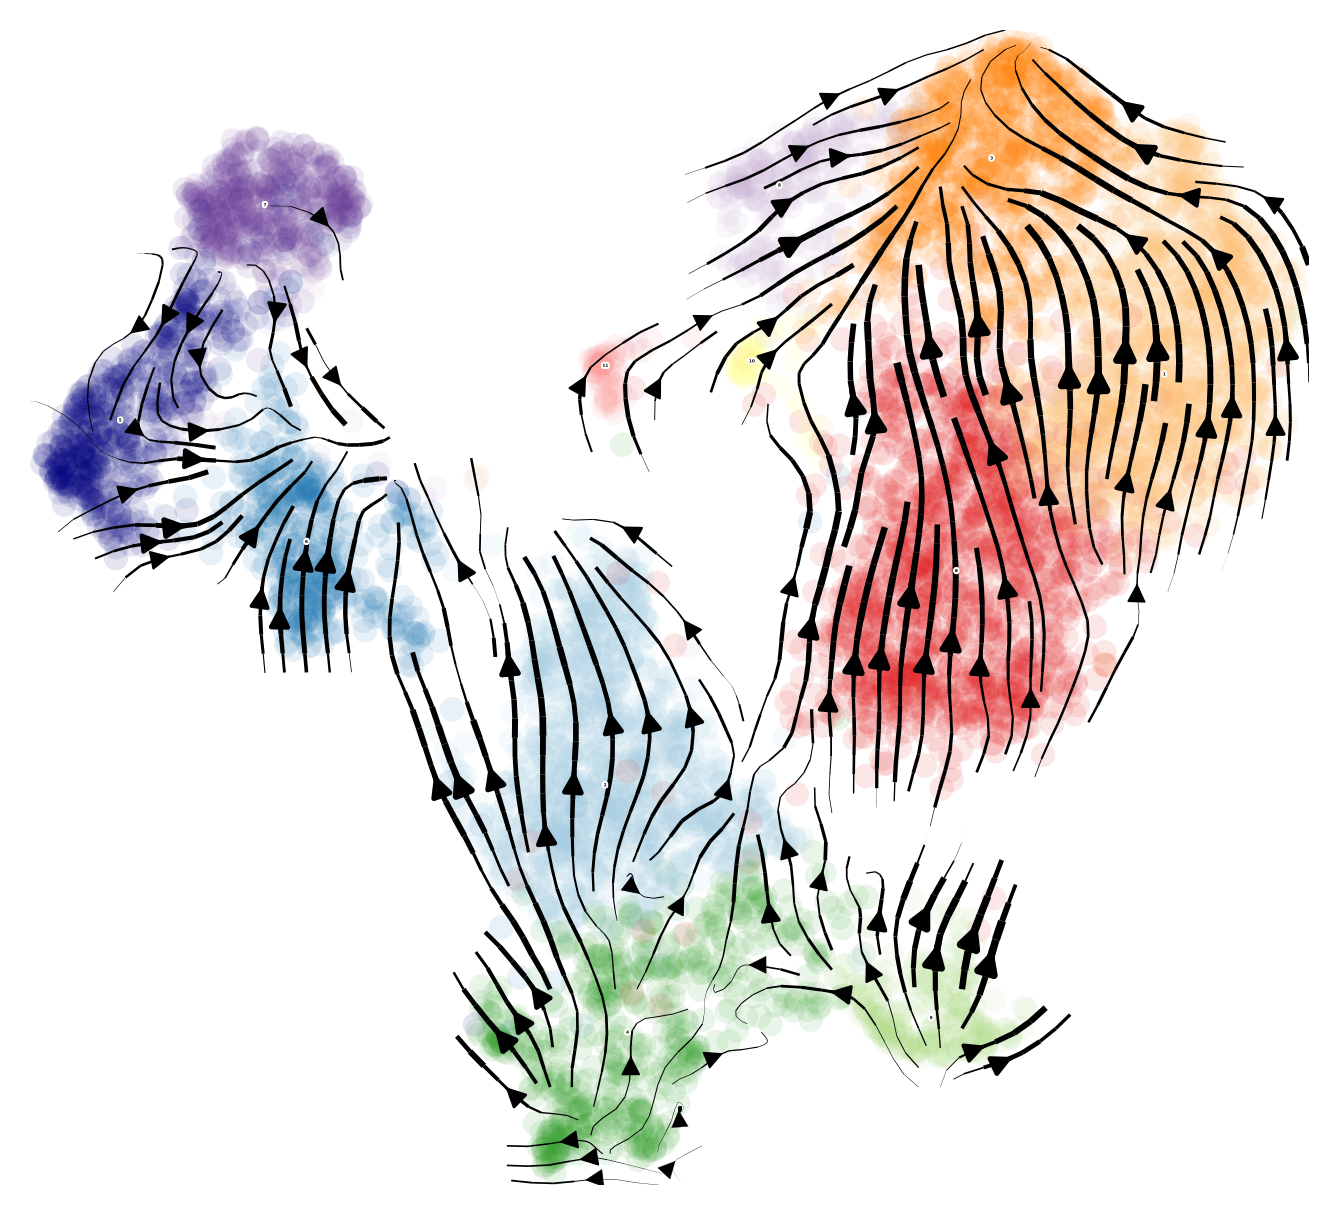

In [28]:
#kwargs = dict(color='clusters', density=.8, add_margin=.1, alpha=.02, min_mass=3.5, add_outline=True, frameon=False)
color_column=["#E31A1C","#FDBF6F","#A6CEE3","#FF7F00","#33A02C","navy","#1F78B4","#6A3D9A", "#CAB2D6","#B2DF8A", "#FFFF99","#FB9A99"]
scv.pl.velocity_embedding_stream(adata,  legend_fontsize=0, basis='umap',dpi=300,alpha=.1,cmap='gnuplot',fontsize=12,palette=color_column, figsize=(5.5, 5),save='I:/Postdoc/Mesenchymal_cells/velocity2.pdf',title='')


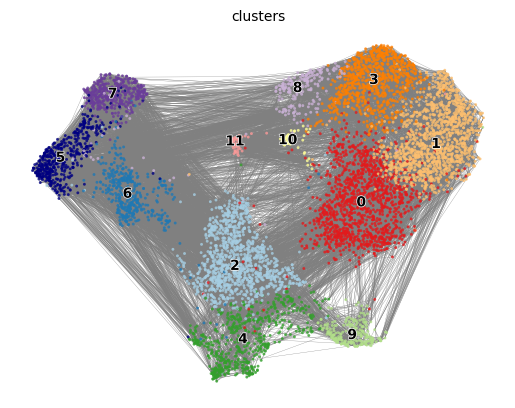

In [29]:
scv.pl.velocity_graph(adata, threshold=.1)

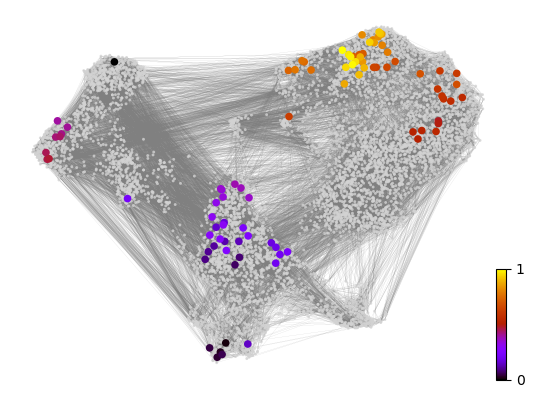

In [30]:
x, y = scv.utils.get_cell_transitions(adata, basis='umap', starting_cell=70)
ax = scv.pl.velocity_graph(adata, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)


In [31]:
my_list = [chow1,chow2,chow3,CDAHFD1,CDAHFD2,BDL1,BDL2]
del my_list[1:7]

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
saving figure to file I:/Postdoc/Mesenchymal_cells/velocity_pseudotime2.pdf


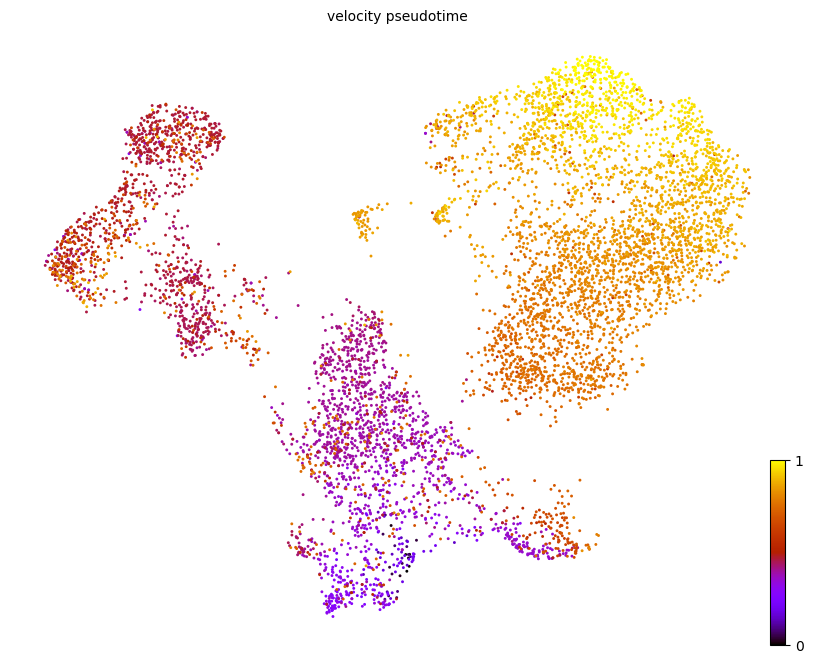

In [32]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot',save='I:/Postdoc/Mesenchymal_cells/velocity_pseudotime2.pdf', figsize=(10, 8))

saving figure to file I:/Postdoc/Mesenchymal_cells/velocity_pseudotime2.pdf


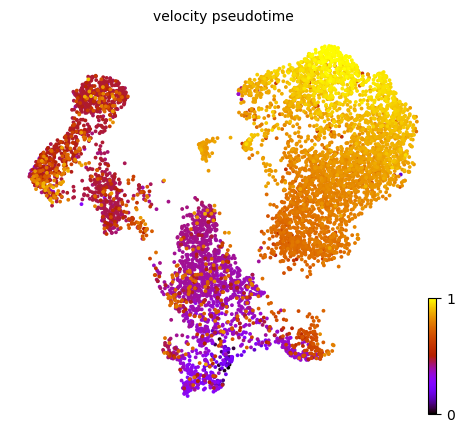

In [33]:
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot',size=30,save='I:/Postdoc/Mesenchymal_cells/velocity_pseudotime2.pdf', figsize=(5.5, 5))

saving figure to file I:/Postdoc/Mesenchymal_cells/velocity_paga.pdf


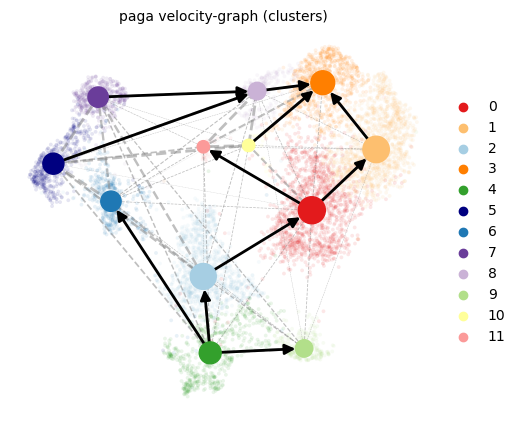

In [49]:
scv.pl.paga(adata, basis='umap',  alpha=.1,
            min_edge_width=2, node_size_scale=1.5, labels=None,palette=color_column,cmap='gnuplot',size=30,save='I:/Postdoc/Mesenchymal_cells/velocity_paga.pdf', figsize=(5.5, 5))